In [ ]:
# Import libraries
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Reinforcement Learning
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Progress bar
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

# Load original JSONL data
def load_jsonl(filepath):
    """Load JSONL file"""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_jsonl('../finetune_paper/train.jsonl')
val_data = load_jsonl('../finetune_paper/val.jsonl')
test_data = load_jsonl('../finetune_paper/test.jsonl')

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

def safe_float(value, default=0.0) -> float:
    """Safely convert a value to float."""
    try:
        return float(value)
    except (TypeError, ValueError):
        return float(default)

def parse_prompt_data(prompt_text):
    """Extract key information from prompt text."""
    lines = prompt_text.split('\n')
    data = {}
    
    for line in lines:
        if 'TICKER:' in line:
            data['ticker'] = line.split('TICKER:')[1].strip()
        elif 'DATE:' in line:
            data['date'] = line.split('DATE:')[1].strip()
        elif 'RECENT CLOSING PRICES' in line:
            if ':' in line:
                prices_part = line.split(':', 1)[1].strip()
                if '(' in prices_part:
                    prices_part = prices_part.split('(')[0].strip()
                try:
                    data['recent_prices'] = [float(p.strip()) for p in prices_part.split(',') if p.strip()]
                except ValueError:
                    data['recent_prices'] = []
    
    return data

print("Data preparation functions defined.")

All libraries imported successfully!
Training samples: 8698
Validation samples: 1243
Test samples: 2477
Data preparation functions defined.


In [ ]:
def load_all_sentiment_data(data_dir='../data_google_news'):
    """Loads and combines sentiment data from all ticker subdirectories."""
    all_sentiment_dfs = []
    for ticker_dir in os.listdir(data_dir):
        sentiment_file = os.path.join(data_dir, ticker_dir, 'sentiment_by_trading_day.csv')
        if os.path.exists(sentiment_file):
            df = pd.read_csv(sentiment_file)
            df['ticker'] = ticker_dir.replace('_', '.')  # Normalize ticker name
            all_sentiment_dfs.append(df)
    
    if not all_sentiment_dfs:
        return pd.DataFrame()
        
    combined_df = pd.concat(all_sentiment_dfs, ignore_index=True)
    combined_df['date'] = pd.to_datetime(combined_df['session_ts']).dt.strftime('%Y-%m-%d')
    return combined_df[['date', 'ticker', 'headline_count', 'sent_compound_mean']]

# Load and display a sample of the sentiment data
sentiment_df = load_all_sentiment_data()
print("Loaded combined sentiment data:")
display(sentiment_df.head())

In [ ]:
# Prepare test data from checkpoint
print("Loading test data from ../results/llm_predictions_checkpoint.json...")
try:
    with open('../results/llm_predictions_checkpoint.json', 'r') as f:
        test_checkpoint = json.load(f)
    test_llm_results = test_checkpoint.get('llm_results', [])

    test_parsed = []
    for idx, item in enumerate(test_data):
        if idx >= len(test_llm_results): break
        parsed = parse_prompt_data(item['prompt'])
        response = json.loads(item['response'])
        llm_output = test_llm_results[idx]

        parsed['llm_prediction'] = safe_float(llm_output.get('predicted_close'), response['predicted_close'])
        parsed['actual_price'] = response['predicted_close']
        parsed['llm_likelihood'] = safe_float(llm_output.get('likelihood'), 0.5)
        test_parsed.append(parsed)

    test_df = pd.DataFrame(test_parsed)
    test_df = pd.merge(test_df, sentiment_df, on=['date', 'ticker'], how='left')
    test_df.fillna({'headline_count': 0, 'sent_compound_mean': 0}, inplace=True)
    
    print(f"Successfully prepared {len(test_df)} test samples.")
    display(test_df.head())
except Exception as e:
    print(f"Error loading test checkpoint: {e}")
    test_df = pd.DataFrame()

# Prepare validation data
print("Preparing validation data...")
try:
    val_parsed = []
    for item in val_data:
        parsed = parse_prompt_data(item['prompt'])
        response = json.loads(item['response'])
        parsed['llm_prediction'] = response['predicted_close']
        parsed['actual_price'] = response['predicted_close']
        parsed['llm_likelihood'] = response.get('likelihood', 0.5)
        val_parsed.append(parsed)

    val_df_ppo = pd.DataFrame(val_parsed)
    val_df_ppo = pd.merge(val_df_ppo, sentiment_df, on=['date', 'ticker'], how='left')
    val_df_ppo.fillna({'headline_count': 0, 'sent_compound_mean': 0}, inplace=True)
    
    print(f"Successfully prepared {len(val_df_ppo)} validation samples.")
    display(val_df_ppo.head())
except Exception as e:
    print(f"Error preparing validation data: {e}")
    val_df_ppo = pd.DataFrame()

# Prepare training data
print("Preparing training data...")
try:
    train_parsed = []
    for item in train_data:
        parsed = parse_prompt_data(item['prompt'])
        response = json.loads(item['response'])
        parsed['llm_prediction'] = response['predicted_close']
        parsed['actual_price'] = response['predicted_close']
        parsed['llm_likelihood'] = response.get('likelihood', 0.5)
        train_parsed.append(parsed)

    train_df_ppo = pd.DataFrame(train_parsed)
    train_df_ppo = pd.merge(train_df_ppo, sentiment_df, on=['date', 'ticker'], how='left')
    train_df_ppo.fillna({'headline_count': 0, 'sent_compound_mean': 0}, inplace=True)
    
    print(f"Successfully prepared {len(train_df_ppo)} training samples.")
    display(train_df_ppo.head())
except Exception as e:
    print(f"Error preparing training data: {e}")
    train_df_ppo = pd.DataFrame()

Loading test data from ../results/llm_predictions_checkpoint.json...
Successfully prepared 2477 test samples.


,ticker,date,recent_prices,llm_prediction,actual_price,llm_likelihood
0,HSBC,2023-01-03,"[31.07, 31.03, 31.21, 31.16, 31.63]",31.63,32.680000,0.8
1,0700.HK,2023-01-03,"[304.1191, 309.8178, 318.3658, 317.226, 327.8636]",0.00,342.870056,0.0
2,PEP,2023-01-03,"[183.07, 181.75, 181.98, 180.66, 179.41]",181.00,178.970001,0.7
3,AAPL,2023-01-03,"[130.03, 126.04, 129.61, 129.93, 125.07]",130.03,126.360001,0.5
4,7203.T,2023-01-04,"[1817.5, 1819.0, 1817.0, 1812.5, 1799.0]",1817.50,1807.500000,0.8


Loading validation data from ../results/llm_predictions_val_checkpoint.json...
Successfully prepared 1243 validation samples.


,ticker,date,recent_prices,llm_prediction,actual_price,llm_likelihood
0,0700.HK,2022-01-03,"[415.2041, 410.0417, 408.7512, 421.104, 418.3385]",420.00,414.835388,0.8
1,HSBC,2022-01-03,"[30.15, 30.22, 30.17, 30.15, 30.45]",30.15,31.820000,0.8
2,AAPL,2022-01-03,"[179.29, 179.38, 178.2, 177.57, 182.01]",179.29,179.699997,0.8
3,PEP,2022-01-03,"[172.36, 172.97, 172.67, 173.71, 172.98]",173.00,173.229996,0.8
4,AAPL,2022-01-04,"[179.38, 178.2, 177.57, 182.01, 179.7]",179.38,174.919998,0.8


Loading training data from ../results/llm_predictions_train_checkpoint.json...
Successfully prepared 8698 training samples.


,ticker,date,recent_prices,llm_prediction,actual_price,llm_likelihood
0,AAPL,2015-01-16,"[27.3125, 27.555, 27.45, 26.705, 26.4975]",27.312500,27.180000,0.8
1,HSBC,2015-01-16,"[45.62, 45.71, 45.24, 45.26, 45.24]",45.620000,45.360001,0.8
2,0700.HK,2015-01-16,"[117.168, 117.8133, 116.1539, 116.9836, 112.3743]",113.078837,113.388344,0.5
3,PEP,2015-01-16,"[96.42, 96.35, 96.67, 96.67, 97.29]",97.290000,97.510002,0.8
4,0700.HK,2015-01-19,"[117.8133, 116.1539, 116.9836, 112.3743, 113.3...",113.388300,114.402382,0.8


In [27]:
# --- Data Quality Check ---
print("="*80)
print("DATA QUALITY CHECK")
print("="*80)

def check_data_quality(df, name):
    missing_prices = df['recent_prices'].apply(lambda x: not isinstance(x, list) or len(x) == 0).sum()
    print(f"{name} - Rows missing 'recent_prices': {missing_prices} / {len(df)}")
    if missing_prices > 0:
        print("   Action: The environment will fall back to using the 'actual_price' for these rows.")

check_data_quality(train_df_ppo, "Training Data")
check_data_quality(val_df_ppo, "Validation Data")
check_data_quality(test_df, "Test Data")

DATA QUALITY CHECK
Training Data - Rows missing 'recent_prices': 0 / 8698
Validation Data - Rows missing 'recent_prices': 0 / 1243
Test Data - Rows missing 'recent_prices': 0 / 2477


In [28]:
# Financial Risk Metrics
def calculate_var(returns: np.ndarray, confidence_level: float = 0.95) -> float:
    """Calculate Value at Risk (VaR)"""
    if len(returns) == 0:
        return 0.0
    return np.percentile(returns, (1 - confidence_level) * 100)

def calculate_cvar(returns: np.ndarray, confidence_level: float = 0.95) -> float:
    """Calculate Conditional Value at Risk (CVaR) - Expected Shortfall"""
    if len(returns) == 0:
        return 0.0
    var = calculate_var(returns, confidence_level)
    tail_losses = returns[returns <= var]
    if len(tail_losses) == 0:
        return var
    return np.mean(tail_losses)

def calculate_volatility(prices: np.ndarray) -> float:
    """Calculate price volatility (standard deviation of returns)"""
    if len(prices) < 2:
        return 0.0
    returns = np.diff(prices) / prices[:-1]
    return np.std(returns)

print("Risk metrics functions defined.")

Risk metrics functions defined.


In [ ]:
class PaperStockEnv(gym.Env):
    """
    A Gym environment that implements the likely reward structure from the paper,
    with configurable weights for accuracy, risk, and improvement bonus.
    Now includes sentiment features in the observation space.
    """
    def __init__(self, data_df: pd.DataFrame, window_size: int = 5,
                 accuracy_weight: float = 1.0, risk_weight: float = 0.5, improvement_weight: float = 0.5):
        super(PaperStockEnv, self).__init__()
        
        self.data = data_df.copy()
        self.window_size = window_size
        self.current_step = 0
        self.max_steps = len(self.data)
        
        self.accuracy_weight = accuracy_weight
        self.risk_weight = risk_weight
        self.improvement_weight = improvement_weight
        
        self.action_space = spaces.Discrete(5)
        self.action_map = {0: -0.02, 1: -0.01, 2: 0.0, 3: 0.01, 4: 0.02}
        
        # Add 2 for sentiment features: headline_count and sent_compound_mean
        state_dim = 1 + window_size + 2 + 1 + 2
        self.observation_space = spaces.Box(low=-5.0, high=5.0, shape=(state_dim,), dtype=np.float32)
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        return self._get_observation(), {}
    
    def _get_observation(self):
        idx = min(self.current_step, self.max_steps - 1)
        
        recent_prices = self.data.iloc[idx].get('recent_prices', [])
        if not isinstance(recent_prices, list) or len(recent_prices) == 0:
            recent_prices = [self.data.iloc[idx]['actual_price']] * self.window_size
        
        last_close = recent_prices[-1] if recent_prices else self.data.iloc[idx]['actual_price']
        
        llm_pred = self.data.iloc[idx]['llm_prediction']
        llm_pred_pct_change = (llm_pred - last_close) / last_close if last_close != 0 else 0.0
        
        hist_prices_pct_change = [(p - last_close) / last_close if last_close != 0 else 0.0 for p in recent_prices]
        
        if len(hist_prices_pct_change) < self.window_size:
            pad_value = hist_prices_pct_change[-1] if hist_prices_pct_change else 0.0
            hist_prices_pct_change += [pad_value] * (self.window_size - len(hist_prices_pct_change))
        
        returns = np.diff(recent_prices) / recent_prices[:-1] if len(recent_prices) > 1 else np.array([0.0])
        volatility = np.std(returns)
        var = np.percentile(returns, 5) if len(returns) > 0 else 0.0
        
        llm_likelihood = self.data.iloc[idx].get('llm_likelihood', 0.5)
        headline_count = self.data.iloc[idx].get('headline_count', 0.0)
        sent_compound_mean = self.data.iloc[idx].get('sent_compound_mean', 0.0)
        
        state = np.concatenate([
            np.array([llm_pred_pct_change], dtype=np.float32),
            np.array(hist_prices_pct_change[-self.window_size:], dtype=np.float32),
            np.array([volatility, var, llm_likelihood, headline_count, sent_compound_mean], dtype=np.float32)
        ])
        
        return np.nan_to_num(state, nan=0.0, posinf=5.0, neginf=-5.0).astype(np.float32)

    def step(self, action):
        idx = min(self.current_step, self.max_steps - 1)
        
        llm_pred = self.data.iloc[idx]['llm_prediction']
        actual_price = self.data.iloc[idx]['actual_price']
        
        adjustment = self.action_map[int(action)]
        adjusted_pred = llm_pred * (1 + adjustment)
        
        pct_error = abs(adjusted_pred - actual_price) / actual_price if actual_price != 0 else 0
        accuracy_reward = -pct_error * 100
        
        recent_prices = self.data.iloc[idx].get('recent_prices', [])
        if not isinstance(recent_prices, list) or len(recent_prices) < 2:
            returns = np.array([0.0])
        else:
            returns = np.diff(recent_prices) / recent_prices[:-1]
        
        cvar = abs(calculate_cvar(returns))
        risk_penalty = -cvar * 100
        
        llm_error = abs(llm_pred - actual_price)
        adjusted_error = abs(adjusted_pred - actual_price)
        improvement_bonus = (llm_error - adjusted_error)
        
        reward = (self.accuracy_weight * accuracy_reward +
                  self.risk_weight * risk_penalty +
                  self.improvement_weight * improvement_bonus)
            
        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False
        
        return self._get_observation(), reward, terminated, truncated, {}

print("Paper's Stock Prediction Environment defined with sentiment features.")

Paper's Stock Prediction Environment defined.


In [30]:
def evaluate_on_validation_paper(model, val_df, window_size=5, **env_kwargs):
    """
    Evaluate the PPO model on the validation set using the PaperStockEnv.
    """
    env = PaperStockEnv(val_df, window_size=window_size, **env_kwargs)
    obs, _ = env.reset()
    
    predictions = []
    actuals = []
    actions = []
    
    for idx in range(len(val_df)):
        if idx < window_size:
            predictions.append(val_df.iloc[idx]['llm_prediction'])
            actuals.append(val_df.iloc[idx]['actual_price'])
            actions.append(2) # Corresponds to 0% adjustment
            continue
        
        action, _ = model.predict(obs, deterministic=True)
        actions.append(int(action))
        adjustment = env.action_map[int(action)]
        
        llm_pred = val_df.iloc[idx]['llm_prediction']
        adjusted_pred = llm_pred * (1 + adjustment)
        predictions.append(adjusted_pred)
        actuals.append(val_df.iloc[idx]['actual_price'])
        
        if idx < len(val_df) - 1:
            obs, _, terminated, _, _ = env.step(action)
            if terminated:
                break
                
    return {
        'mae': np.mean(np.abs(np.array(predictions) - np.array(actuals))),
        'predictions': predictions,
        'actions': actions
    }

print("Evaluation function for paper's environment defined.")

Evaluation function for paper's environment defined.


In [31]:
import itertools

# --- 7. Hyperparameter Search (Paper's Method) ---
print("="*80)
print("PPO HYPERPARAMETER SEARCH (PAPER'S METHOD)")
print("="*80)

llm_val_mae_baseline = np.mean(np.abs(val_df_ppo['llm_prediction'] - val_df_ppo['actual_price']))
print(f"Target to Beat: {llm_val_mae_baseline:.4f} (LLM-only validation MAE)")

# Expanded hyperparameter grid including reward weights
param_grid_paper = {
    'learning_rate': [5e-5],
    'n_steps': [2048],
    'ent_coef': [0.01],
    'accuracy_weight': [1.0, 0.5],
    'risk_weight': [0.5, 1.0],
    'improvement_weight': [0.5, 1.0],
}

all_configs = [dict(zip(param_grid_paper.keys(), v)) for v in itertools.product(*param_grid_paper.values())]
print(f"Testing {len(all_configs)} configurations.")

# --- Training Loop ---
search_results_paper = []

for config_idx, config in enumerate(all_configs):
    print(f"--- Training Config {config_idx + 1}/{len(all_configs)}: {config} ---")
    
    try:
        env_kwargs = {k: config.pop(k) for k in ['accuracy_weight', 'risk_weight', 'improvement_weight']}
        
        train_env = PaperStockEnv(train_df_ppo, window_size=5, **env_kwargs)
        model = PPO("MlpPolicy", train_env, verbose=0, **config)
        model.learn(total_timesteps=40000, progress_bar=True)
        
        eval_results = evaluate_on_validation_paper(model, val_df_ppo, **env_kwargs)
        eval_results['config'] = config
        eval_results['env_kwargs'] = env_kwargs
        search_results_paper.append(eval_results)
        
        print(f"Validation MAE: {eval_results['mae']:.4f} (Improvement: {((llm_val_mae_baseline - eval_results['mae']) / llm_val_mae_baseline) * 100:+.2f}%)")
        
    except Exception as e:
        print(f"Error with config {config}: {e}")

# --- 8. Analyze and Save Best Model ---
if search_results_paper:
    best_result = min(search_results_paper, key=lambda x: x['mae'])
    
    print("\n" + "="*80)
    print("SEARCH COMPLETE (PAPER'S METHOD)")
    print(f"Best PPO Config: {best_result['config']}")
    print(f"Best Env Config: {best_result['env_kwargs']}")
    print(f"Best Validation MAE: {best_result['mae']:.4f}")
    
    print("\n--- Training Final Model ---")
    final_env = PaperStockEnv(train_df_ppo, window_size=5, **best_result['env_kwargs'])
    final_model = PPO("MlpPolicy", final_env, verbose=0, **best_result['config'])
    final_model.learn(total_timesteps=80000, progress_bar=True)
    
    model_path = "../results/ppo_paper_final_model.zip"
    final_model.save(model_path)
    print(f"✅ Final model saved to {model_path}")
    
else:
    print("No results from hyperparameter search.")

PPO HYPERPARAMETER SEARCH (PAPER'S METHOD)
Target to Beat: 58.9895 (LLM-only validation MAE)
Testing 8 configurations.
--- Training Config 1/8: {'learning_rate': 5e-05, 'n_steps': 2048, 'ent_coef': 0.01, 'accuracy_weight': 1.0, 'risk_weight': 0.5, 'improvement_weight': 0.5} ---


Validation MAE: 58.9153 (Improvement: +0.13%)
--- Training Config 2/8: {'learning_rate': 5e-05, 'n_steps': 2048, 'ent_coef': 0.01, 'accuracy_weight': 1.0, 'risk_weight': 0.5, 'improvement_weight': 1.0} ---


Validation MAE: 58.9895 (Improvement: +0.00%)
--- Training Config 3/8: {'learning_rate': 5e-05, 'n_steps': 2048, 'ent_coef': 0.01, 'accuracy_weight': 1.0, 'risk_weight': 1.0, 'improvement_weight': 0.5} ---


Validation MAE: 58.9147 (Improvement: +0.13%)
--- Training Config 4/8: {'learning_rate': 5e-05, 'n_steps': 2048, 'ent_coef': 0.01, 'accuracy_weight': 1.0, 'risk_weight': 1.0, 'improvement_weight': 1.0} ---


Validation MAE: 58.9895 (Improvement: +0.00%)
--- Training Config 5/8: {'learning_rate': 5e-05, 'n_steps': 2048, 'ent_coef': 0.01, 'accuracy_weight': 0.5, 'risk_weight': 0.5, 'improvement_weight': 0.5} ---


Validation MAE: 58.9895 (Improvement: +0.00%)
--- Training Config 6/8: {'learning_rate': 5e-05, 'n_steps': 2048, 'ent_coef': 0.01, 'accuracy_weight': 0.5, 'risk_weight': 0.5, 'improvement_weight': 1.0} ---


Validation MAE: 58.9892 (Improvement: +0.00%)
--- Training Config 7/8: {'learning_rate': 5e-05, 'n_steps': 2048, 'ent_coef': 0.01, 'accuracy_weight': 0.5, 'risk_weight': 1.0, 'improvement_weight': 0.5} ---


Validation MAE: 58.9895 (Improvement: +0.00%)
--- Training Config 8/8: {'learning_rate': 5e-05, 'n_steps': 2048, 'ent_coef': 0.01, 'accuracy_weight': 0.5, 'risk_weight': 1.0, 'improvement_weight': 1.0} ---


Validation MAE: 58.9895 (Improvement: +0.00%)

SEARCH COMPLETE (PAPER'S METHOD)
Best PPO Config: {'learning_rate': 5e-05, 'n_steps': 2048, 'ent_coef': 0.01}
Best Env Config: {'accuracy_weight': 1.0, 'risk_weight': 1.0, 'improvement_weight': 0.5}
Best Validation MAE: 58.9147

--- Training Final Model ---


✅ Final model saved to ../results/ppo_paper_final_model.zip


In [32]:
# --- 9. Final Evaluation on Test Set (Paper's Method) ---
import pandas as pd
import numpy as np
from stable_baselines3 import PPO

print("="*80)
print("FINAL EVALUATION ON TEST SET (PAPER'S METHOD)")
print("="*80)

try:
    # Load the final model and best environment config
    final_model = PPO.load("../results/ppo_paper_final_model.zip")
    best_env_kwargs = best_result['env_kwargs']
    print("Loaded final model and environment configuration.")

    # Evaluate on the test set
    test_results = evaluate_on_validation_paper(final_model, test_df, **best_env_kwargs)
    
    llm_test_mae = np.mean(np.abs(test_df['llm_prediction'] - test_df['actual_price']))
    ppo_test_mae = test_results['mae']
    improvement = ((llm_test_mae - ppo_test_mae) / llm_test_mae) * 100
    
    print(f"\n--- Test Set Performance ---")
    print(f"LLM-Only MAE:        {llm_test_mae:.4f}")
    print(f"PPO (Paper) MAE:     {ppo_test_mae:.4f}")
    print(f"Improvement:         {improvement:+.2f}%")
    
    # Save predictions
    test_df['ppo_paper_prediction'] = test_results['predictions']
    test_df.to_csv("../results/test_predictions_paper_ppo.csv", index=False)
    print("\nTest predictions saved to ../results/test_predictions_paper_ppo.csv")

except FileNotFoundError:
    print("Model file not found. Please run the training cell first.")
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

FINAL EVALUATION ON TEST SET (PAPER'S METHOD)
Loaded final model and environment configuration.

--- Test Set Performance ---
LLM-Only MAE:        62.1152
PPO (Paper) MAE:     62.3913
Improvement:         -0.44%

Test predictions saved to ../results/test_predictions_paper_ppo.csv



ANALYZING AGENT BEHAVIOR ON TEST SET


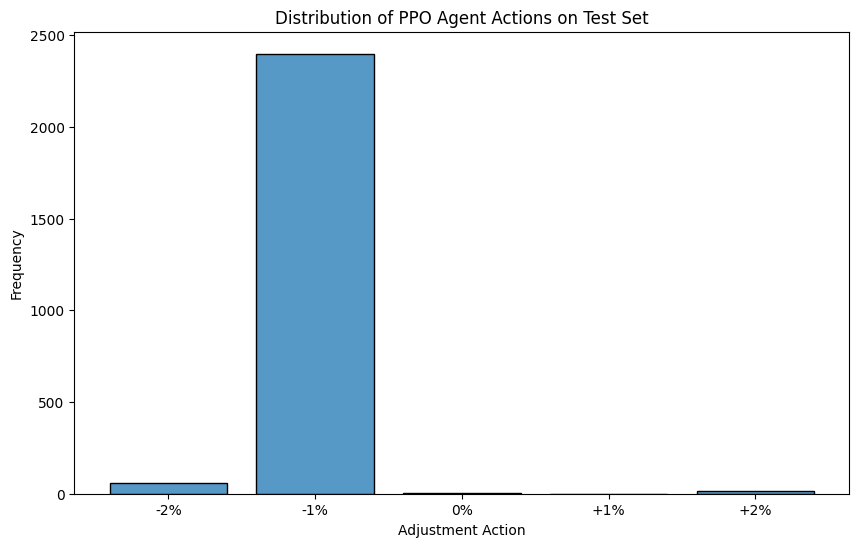

Action distribution:
  -2%: 59 times
  -1%: 2400 times
  0%: 5 times
  +2%: 13 times


In [33]:
# --- 10. Analyze Agent Behavior ---
if 'test_results' in locals() and 'actions' in test_results:
    print("\n" + "="*80)
    print("ANALYZING AGENT BEHAVIOR ON TEST SET")
    print("="*80)
    
    actions = test_results['actions']
    action_labels = {0: '-2%', 1: '-1%', 2: '0%', 3: '+1%', 4: '+2%'}
    
    plt.figure(figsize=(10, 6))
    sns.histplot(actions, bins=np.arange(6) - 0.5, shrink=0.8, discrete=True)
    plt.xticks(ticks=list(action_labels.keys()), labels=list(action_labels.values()))
    plt.title('Distribution of PPO Agent Actions on Test Set')
    plt.xlabel('Adjustment Action')
    plt.ylabel('Frequency')
    plt.show()
    
    # Print summary
    action_counts = pd.Series(actions).value_counts().sort_index()
    print("Action distribution:")
    for action_idx, count in action_counts.items():
        print(f"  {action_labels[action_idx]}: {count} times")
else:
    print("\nRun the final evaluation cell to generate action data for analysis.")